# Convolutional LSTM Learning

# Installation
Need to downgrade numpy
- `conda create --name tf tensorflow=2.4`
- `conda activate tf`
- `conda install numpy=1.19`
- `conda install jupyterlab matplotlib pandas`
- https://stackoverflow.com/questions/66207609/notimplementederror-cannot-convert-a-symbolic-tensor-lstm-2-strided-slice0-t

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle, os

2023-12-03 06:18:15.344095: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-03 06:18:15.344146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-03 06:18:15.344871: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-03 06:18:15.351260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-03 06:18:16.008540: W tensorflow/compiler/tf2

In [2]:
# Data folder
folderName = '2023-12-03-05-57-02'

cwd = os.getcwd()
filePath = os.path.join(cwd, "output", folderName, 'data_store.pickle')

In [3]:
# Load data (deserialize)
with open(filePath, 'rb') as handle:
    data_dict = pickle.load(handle)

data = data_dict["data"]
nCol = data_dict["n"]
nRow = 1
nChannel = 1
# tFinal = data_dict["tf"]
dx = data_dict["dx"]
L = data_dict["L"]

In [4]:
nSeq = 10

In [5]:
def split_sequence(data, nSeq):

    X, y = list(), list()
    nRow = data.shape[0]
    for i in range(nRow):
		# find the end of this pattern
        end_ix = i + nSeq
		# check if we are beyond the sequence
        if end_ix > nRow - 1:
            break
		# gather input and output parts of the pattern
        seq_x, seq_y = data[i:end_ix, :], data[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [6]:
X_, y = split_sequence(data, nSeq)
print(X_.shape)
print(y.shape)

(91, 10, 32)
(91, 32)


In [7]:
X_.shape

(91, 10, 32)

In [8]:
X = X_.reshape(X_.shape[0], nSeq, nRow, nCol, nChannel)

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, SimpleRNN, GRU, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D

def createModel(type):
    inputLayer = Input(shape=(nSeq, nRow, nCol, nChannel))

    if (type == 'ConvLSTM'):
        layer = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(inputLayer)
        layer = Flatten()(layer)
    
    outputLayer = Dense(nCol)(layer)
    model = Model(inputs=inputLayer, outputs=outputLayer, name=type)

    return model

In [10]:
# Model building
tf.keras.backend.clear_session()
tf.random.set_seed(1)
# For somereason if I don't include this, I cannot execute this cell twice for LSTM and GRU
from tensorflow.keras.layers import LSTM, GRU

ConvLSTM = createModel('ConvLSTM')

ConvLSTM.summary()

2023-12-03 06:18:16.790631: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "ConvLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1, 32, 1)]    0         
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 1, 30, 64)         50176     
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 32)                61472     
                                                                 
Total params: 111648 (436.12 KB)
Trainable params: 111648 (436.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2023-12-03 06:18:16.815978: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 06:18:16.816028: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 06:18:16.818257: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 06:18:16.818304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:09:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-03 06:18:16.818328: I external/local_xla/xla/stream_executor

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

def runModel(model, X, y, **kwargs):

    learning_rate = 0.001
    if 'learning_rate' in kwargs:
        learning_rate = kwargs['learning_rate']

    patience = 2
    if 'patience' in kwargs:
        patience = kwargs['patience']

    epochs=200
    if 'epochs' in kwargs:
        epochs = kwargs['epochs']

    optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse')

    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=1e-5)

    history = model.fit(X, y, epochs=epochs, verbose=1, callbacks=[earlyStoppingCallback ])

    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)
    plt.show()

Epoch 1/2000


2023-12-03 06:18:18.684405: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2023-12-03 06:18:19.774152: I external/local_xla/xla/service/service.cc:168] XLA service 0x7ff50ca14900 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-03 06:18:19.774203: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-12-03 06:18:19.780051: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701559099.856277   13431 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 [==============================] - 4s 191ms/step - loss: 0.0700
Epoch 2/2000
3/3 [==============================] - 0s 106ms/step - loss: 0.0418
Epoch 3/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.0137
Epoch 4/2000
3/3 [==============================] - 0s 91ms/step - loss: 0.0100
Epoch 5/2000
3/3 [==============================] - 0s 90ms/step - loss: 0.0031
Epoch 6/2000
3/3 [==============================] - 0s 102ms/step - loss: 0.0030
Epoch 7/2000
3/3 [==============================] - 0s 69ms/step - loss: 0.0039
Epoch 8/2000
3/3 [==============================] - 0s 79ms/step - loss: 0.0024
Epoch 9/2000
3/3 [==============================] - 0s 69ms/step - loss: 0.0012
Epoch 10/2000
3/3 [==============================] - 0s 84ms/step - loss: 0.0013
Epoch 11/2000
3/3 [==============================] - 0s 75ms/step - loss: 7.7157e-04
Epoch 12/2000
3/3 [==============================] - 0s 76ms/step - loss: 4.3699e-04
Epoch 13/2000
3/3 [====================

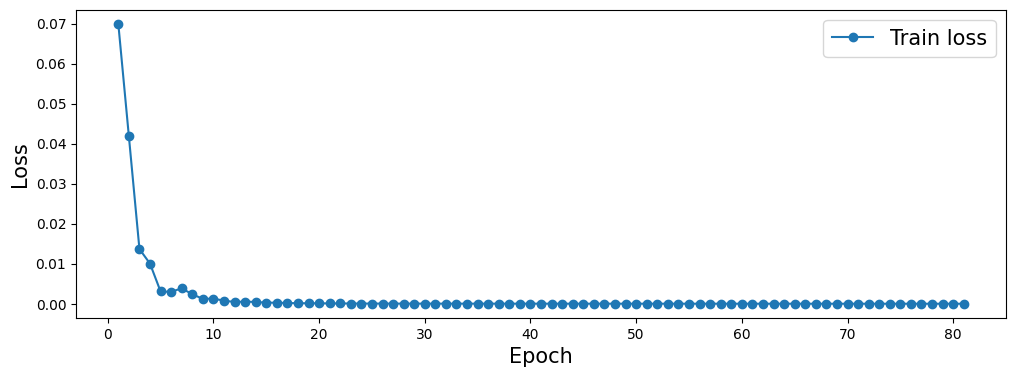

In [12]:
runModel(ConvLSTM, X, y, learning_rate=0.001, epochs=2000, patience=30)

In [13]:
def predictValue(model, X_):
    X = X_.reshape((1, nSeq, nRow, nCol, nChannel))
    yhat_ = model.predict(X, verbose=0)
    yhat = yhat_.flatten()
    return yhat

In [14]:
X_ = data[1:1+nSeq, :]
predictValue(ConvLSTM, X_)

array([0.23194732, 0.1769399 , 0.13315414, 0.12692583, 0.16829646,
       0.2312912 , 0.27967092, 0.28540602, 0.24908532, 0.19151326,
       0.14974707, 0.1463615 , 0.1823635 , 0.23257048, 0.2650342 ,
       0.2507094 , 0.19606487, 0.13814102, 0.11101321, 0.13207409,
       0.18424729, 0.24367453, 0.27653402, 0.2580755 , 0.21173015,
       0.15997836, 0.13286462, 0.14314973, 0.184156  , 0.23912783,
       0.27415928, 0.27340126], dtype=float32)

array([0.23194732, 0.1769399 , 0.13315414, 0.12692583, 0.16829646,
       0.2312912 , 0.27967092, 0.28540602, 0.24908532, 0.19151326,
       0.14974707, 0.1463615 , 0.1823635 , 0.23257048, 0.2650342 ,
       0.2507094 , 0.19606487, 0.13814102, 0.11101321, 0.13207409,
       0.18424729, 0.24367453, 0.27653402, 0.2580755 , 0.21173015,
       0.15997836, 0.13286462, 0.14314973, 0.184156  , 0.23912783,
       0.27415928, 0.27340126], dtype=float32)

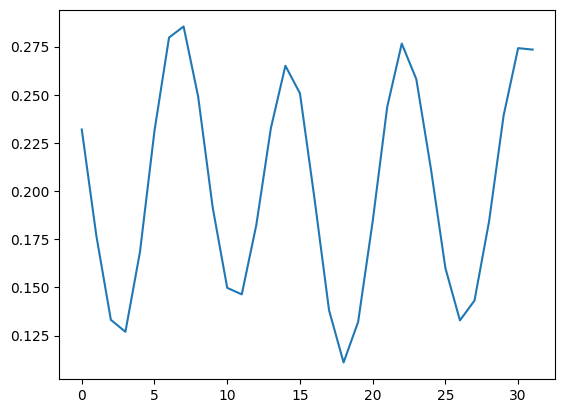

In [15]:
plt.plot(predictValue(ConvLSTM, X_))
predictValue(ConvLSTM, X_)

In [16]:
def calculateForecast(model, X_, nForecast):
    yA = list()
    
    for i in range(nSeq):
        yA.append(X_[i,:])
    
    for i in range(nForecast):
        XA = np.array(yA[-nSeq:])
        X = XA.reshape((1, nSeq, nRow, nCol, nChannel))
        yhat = predictValue(model, X)
        yA.append(yhat)

    return np.array(yA[nSeq:])

In [17]:
tFinal = data.shape[0]
nForecast = tFinal - nSeq
yPred = calculateForecast(ConvLSTM, data[:nSeq,:], nForecast)

In [18]:
yPred.shape



(91, 32)

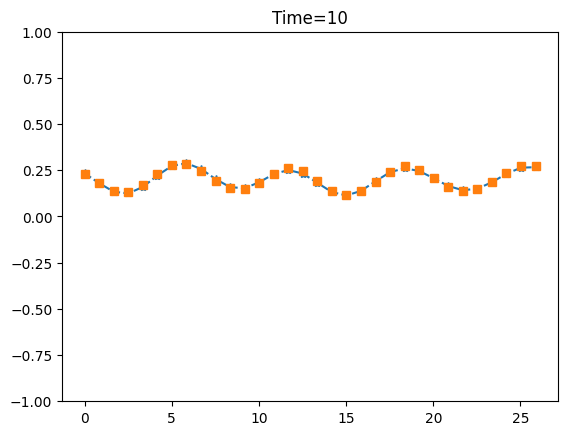

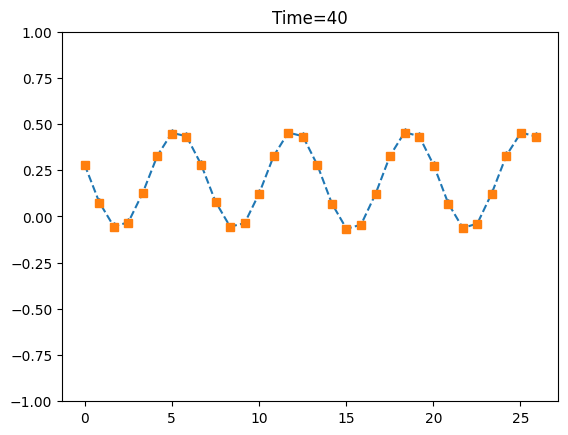

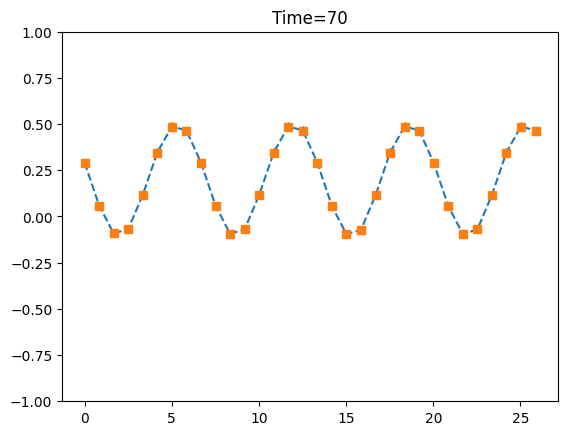

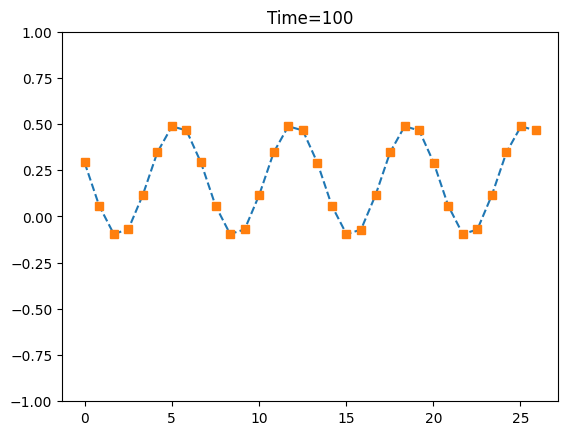

In [19]:
xp = np.arange(0,L,dx)
for t in range(0, tFinal, 30):
    fig, ax = plt.subplots()
    yPFC = y[t,:]
    yML = yPred[t,:]
    ax.plot(xp, yPFC, '*--')
    ax.plot(xp, yML,'s')
    ax.set_title(f'Time={t+nSeq}')
    ax.set_ylim([-1,1])


Text(0.5, 0, 'Time')

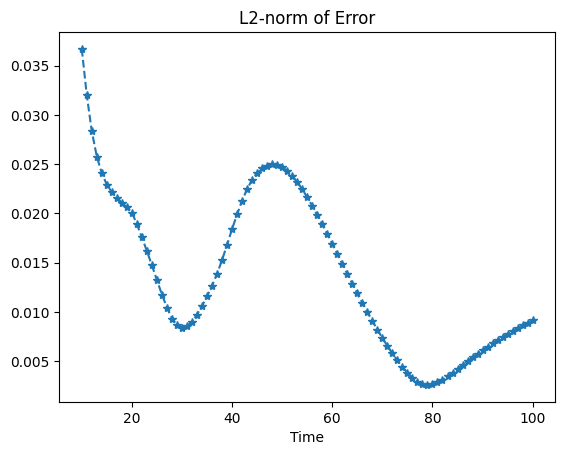

In [20]:
xp = np.arange(nSeq,tFinal)
errL2 = list()
for t in range(y.shape[0]):
    yPFC = y[t,:]
    yML = yPred[t,:]
    errL2.append(np.linalg.norm(yPFC-yML))
errL2 = np.array(errL2)

fig, ax = plt.subplots()
ax.plot(xp, errL2,'--*')
ax.set_title(r'L2-norm of Error')
ax.set_xlabel('Time')
